In [34]:
from gbm import test_data_dir
from gbm.data import TTE
from gbm.binning.unbinned import bin_by_time
import matplotlib.pyplot as plt
from gbm.data import PosHist
from gbm.data import Trigdat
from gbm.time import Met

In [35]:
print('What GRB lc do you want to plot?')
#GRB090820027
#GRB090902462
#GRB120624933
#GRB130427324
GRB = '130427324'#input()
data_selected = GRB.replace('GRB','')
tte=TTE.open('bn'+str(data_selected)+'/glg_tte_n0_bn'+str(data_selected)+'_v00.fit')

What GRB lc do you want to plot?


In [36]:
trigdat = Trigdat.open('bn'+str(data_selected)+'/glg_trigdat_all_bn'+str(data_selected)+'_v01.fit')
trigdat.headers.keys()
phaii = trigdat.to_ctime('n0')
trig_dets = trigdat.triggered_detectors
print('triggered detectors are:',str(trig_dets))

triggered detectors are: ['n6', 'n9', 'na', 'nb']


In [37]:
daily_data=str(data_selected)[0:6]
poshist = PosHist.open('bn'+str(data_selected)+'/glg_poshist_all_'+str(daily_data)+'_v00.fit')
poshist.get_saa_passage(tte.trigtime)
for i in range (len(trig_dets)):
    print(poshist.detector_pointing(trig_dets[i],tte.trigtime))

(array(237.96040552), array(51.12719716))
(array(180.36959589), array(27.44841937))
(array(156.63887684), array(-12.39818322))
(array(219.04938811), array(-22.08473509))


In [38]:
#Check on the angular distance between the GRB position and the 
#detector pointing. Are selected only detector whose ang_dis<60 deg
import numpy as np

# read the file into a list of lines
with open('source_localization.txt','r') as f:
    lines = f.read().split("\n")

word = data_selected # dummy word. you take it from input
d=-1
# iterate over lines, and print out line numbers which contain
# the word of interest.
for i,line in enumerate(lines):
    d=d+1
    if word in line: # or word in line.split() to search for full words
        c=d
        
data=np.genfromtxt('source_localization.txt')
GRB_ra=data[c,1]
GRB_dec=data[c,2]

with open('source_localization.txt','r') as f:
    print(f.read())

print('Ra and Dec position of the burst'+'bn'+str(data_selected)+':',str(GRB_ra),',',str(GRB_dec))

GRB        Ra    Dec
bn090820027 87.7 27.7
bn090902462 264.9 27.3
bn120624933 170.9 8.9
bn130427324 173.1 27.7

Ra and Dec position of the burstbn130427324: 173.1 , 27.7


In [39]:
detection_angle=np.zeros(len(trig_dets))
checked_detectors=[]
for det in range (len(trig_dets)):
    detection_angle[det]=poshist.detector_angle(GRB_ra,GRB_dec,trig_dets[det],tte.trigtime)
    print(trig_dets[det],'angular distance to the src is',detection_angle[det])
    if(detection_angle[det]<60):
        checked_detectors.append(trig_dets[det])
print('Triggered detectors that see the GRB with an angular distance <60 deg are:')
print(checked_detectors)

n6 angular distance to the src is 53.27605988848988
n9 angular distance to the src is 6.447830505303378
na angular distance to the src is 43.15568769905921
nb angular distance to the src is 66.69220582384455
Triggered detectors that see the GRB with an angular distance <60 deg are:
['n6', 'n9', 'na']


In [40]:
# open TTEs file as a list to merge at the end
#Detectors selected are those who triggered the burst and see it with
#an angular distanc <60 deg
tte_merge=[]

for i in range (len(checked_detectors)):
    print('reading file:','bn'+str(data_selected)+'/glg_tte_'+str(checked_detectors[i])+'_bn'+str(data_selected)+'_v00.fit')
    n_i=TTE.open('bn'+str(data_selected)+'/glg_tte_'+str(checked_detectors[i])+'_bn'+str(data_selected)+'_v00.fit')
    tte_merge.append(n_i)

reading file: bn130427324/glg_tte_n6_bn130427324_v00.fit
reading file: bn130427324/glg_tte_n9_bn130427324_v00.fit
reading file: bn130427324/glg_tte_na_bn130427324_v00.fit


In [41]:
# print the metadata in the PRIMARY header
tte=TTE.merge(tte_merge, force_unique=True)
tte.headers['PRIMARY']

CREATOR = 'GBM Data Tools 1.1.1 Software and version creating file'             
FILETYPE= 'GBM PHOTON LIST'    / Name for this type of FITS file                
FILE-VER= '1.0.0   '           / Version of the format for this filetype        
TELESCOP= 'GLAST   '           / Name of mission/satellite                      
INSTRUME= 'GBM     '           / Specific instrument used for observation       
DETNAM  = 'NAI_06  '           / Individual detector name                       
OBSERVER= 'Meegan  '           / GLAST Burst Monitor P.I.                       
ORIGIN  = 'GIOC    '           / Name of organization making file               
DATE    = '2023-02-03T16:05:26' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
DATE-OBS= '2013-04-27T07:44:50' / Date of start of observation                  
DATE-END= '2013-04-27T07:55:04' / Date of end of observation                    
TIMESYS = 'TT      '           / Time system used in time keywords              
TIMEUNIT= 's       '        

In [42]:
s=str(tte.headers['PRIMARY'])
start='DATE-OBS'
end='Date of start of observation'
s=(s.split(start))[1].split(end)[0]
import re
last_num=re.findall(r'\d+', s)[-1]
temp=re.findall(r'^\D*(\d+)',s)
first_num=temp[0]
start=str(first_num)
end=str(last_num)
s=(s.split(start))[1].split(end)[0]
data_obs=start+s+end
met=Met.from_iso(str(data_obs))
data_obs_met=met.met

In [60]:
GRB_trig_time=int(tte.trigtime-data_obs_met)
BKG_start_time=int(tte.trigtime-data_obs_met+tte.time_range[0])
print(GRB_trig_time)
print(BKG_start_time)

136
0


In [44]:
# bin to 1.024 s resolution, reference time is trigger time
phaii = tte.to_phaii(bin_by_time, 1.024, time_ref=0.0)
%matplotlib inline

In [45]:
#Producing the Light curve
from gbm.plot import Lightcurve, Spectrum
#Selecting Energy range and time interval of the light curve
erange = (50.0, 300.0)
time_split = tte.gti[0]
lc_data = phaii.to_lightcurve(time_range=time_split,energy_range=erange)

In [46]:
#BKG extimation, selecting the BKG intervals
bkgd_times = [(time_split[0],BKG_start_time-5), (GRB_trig_time+50,time_split[1])]
print(bkgd_times)

[(-136.193952023983, -5), (186, 478.21507197618484)]


In [47]:
# the background fitter interface
from gbm.background import BackgroundFitter
# GBM fitting algorithm
from gbm.background.binned import Polynomial
# we initialize our background fitter with the phaii object, the algorithm, and the time ranges to fit.
# if we were using an unbinned algorithm, we'd call .from_tte() and give it tte instead of phaii
backfitter = BackgroundFitter.from_phaii(phaii, Polynomial, time_ranges=bkgd_times)

In [48]:
# and once initialized, we can run the fit with the fitting parameters appropriate for our algorithm.
# here, we'll do a 2st order polynomial
backfitter.fit(order=1)
#backfitter.statistic/backfitter.dof
bkgd = backfitter.interpolate_bins(phaii.data.tstart, phaii.data.tstop)

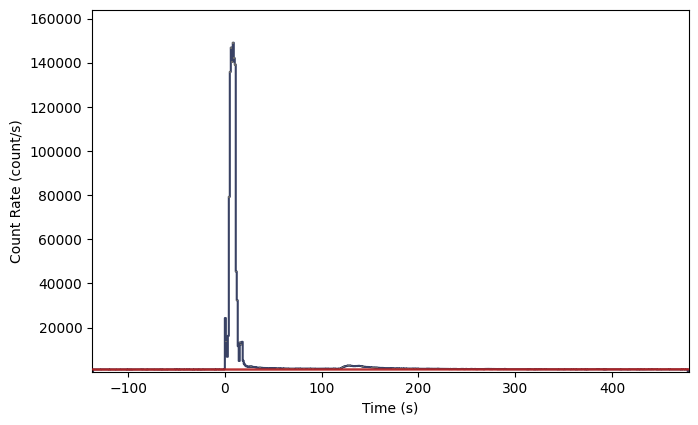

In [49]:
lc_bkgd = bkgd.integrate_energy(*erange)
lcplot = Lightcurve(data=lc_data, background=lc_bkgd)
plt.show()

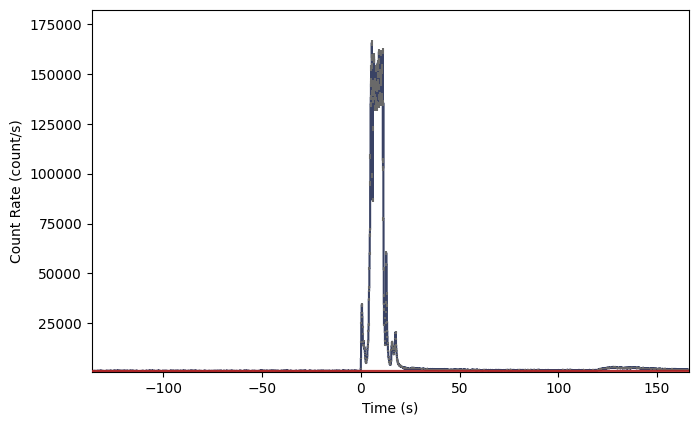

In [50]:
# bin to 0.1 s resolution, reference time is trigger time
phaii = tte.to_phaii(bin_by_time, 0.1, time_ref=0.0)
%matplotlib inline
#Producing the Light curve
from gbm.plot import Lightcurve, Spectrum
#Selecting Energy range and time interval of the light curve
erange = (50.0, 300.0)
#Selecting a new time interval to plot the lc
time_split = (time_split[0], GRB_trig_time+30)
lc_data = phaii.to_lightcurve(time_range=time_split,energy_range=erange)
#BKG extimation, selecting the BKG intervals
bkgd_times = [(time_split[0], BKG_start_time)]
# the background fitter interface
from gbm.background import BackgroundFitter
# GBM fitting algorithm
from gbm.background.binned import Polynomial
# we initialize our background fitter with the phaii object, the algorithm, and the time ranges to fit.
# if we were using an unbinned algorithm, we'd call .from_tte() and give it tte instead of phaii
backfitter = BackgroundFitter.from_phaii(phaii, Polynomial, time_ranges=bkgd_times)
# and once initialized, we can run the fit with the fitting parameters appropriate for our algorithm.
# here, we'll do a 2st order polynomial
backfitter.fit(order=1)
#backfitter.statistic/backfitter.dof
bkgd = backfitter.interpolate_bins(phaii.data.tstart, phaii.data.tstop)
lc_bkgd = bkgd.integrate_energy(*erange)
lcplot = Lightcurve(data=lc_data, background=lc_bkgd)
plt.show()

In [65]:
if min(phaii.data.tstart)<-50 or max(phaii.data.tstart)>150:
    print('time intervall:',min(phaii.data.tstart),max(phaii.data.tstart))
    print('zoom needed')
    new_time_slice=(-50,50)


time intervall: -136.20000000000002 478.20000000000005
zoom needed


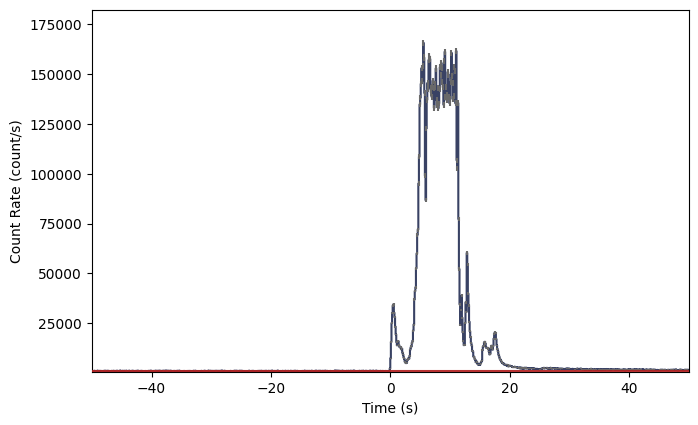

In [66]:
lc_data = phaii.to_lightcurve(time_range=new_time_slice,energy_range=erange)
#BKG extimation, selecting the BKG intervals
bkgd_times = [(time_split[0], BKG_start_time)]
# the background fitter interface
from gbm.background import BackgroundFitter
# GBM fitting algorithm
from gbm.background.binned import Polynomial
# we initialize our background fitter with the phaii object, the algorithm, and the time ranges to fit.
# if we were using an unbinned algorithm, we'd call .from_tte() and give it tte instead of phaii
backfitter = BackgroundFitter.from_phaii(phaii, Polynomial, time_ranges=bkgd_times)
# and once initialized, we can run the fit with the fitting parameters appropriate for our algorithm.
# here, we'll do a 2st order polynomial
backfitter.fit(order=1)
#backfitter.statistic/backfitter.dof
bkgd = backfitter.interpolate_bins(phaii.data.tstart, phaii.data.tstop)
lc_bkgd = bkgd.integrate_energy(*erange)
lcplot = Lightcurve(data=lc_data, background=lc_bkgd)
plt.show()

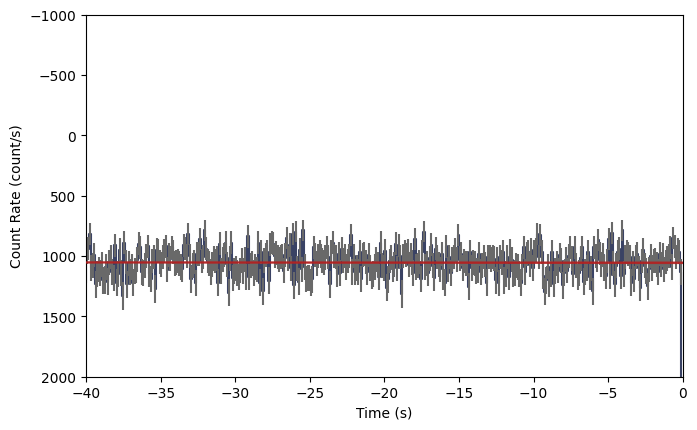

In [98]:
#BKG zooming
lc_data = phaii.to_lightcurve(time_range=new_time_slice,energy_range=erange)
#BKG extimation, selecting the BKG intervals
bkgd_times = [(time_split[0], BKG_start_time)]
# the background fitter interface
from gbm.background import BackgroundFitter
# GBM fitting algorithm
from gbm.background.binned import Polynomial
# we initialize our background fitter with the phaii object, the algorithm, and the time ranges to fit.
# if we were using an unbinned algorithm, we'd call .from_tte() and give it tte instead of phaii
backfitter = BackgroundFitter.from_phaii(phaii, Polynomial, time_ranges=bkgd_times)
# and once initialized, we can run the fit with the fitting parameters appropriate for our algorithm.
# here, we'll do a 2st order polynomial
backfitter.fit(order=1)
#backfitter.statistic/backfitter.dof
bkgd = backfitter.interpolate_bins(phaii.data.tstart, phaii.data.tstop)
lc_bkgd = bkgd.integrate_energy(*erange)
lcplot = Lightcurve(data=lc_data, background=lc_bkgd)
plt.axis([-40,0,2000,-1000])
plt.show()